# The Hamilton Filter


In [1]:
#Importing packages we need
import numpy as np
import matplotlib.pyplot as plt #pyplot is used to plot the data
import scipy.optimize as opt #used to numerically optimize
from datetime import time, timedelta, datetime
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
data=np.genfromtxt('SP500.csv', delimiter=',',usecols=np.arange(0,4)) #loading in first 4 columns
y = data[15097:, 3:4]*100 # 100 times log-returns of the S&P 500 index. January 4, 2010 - till end
y=y.T[0,:] #unpacking numpy array
T = len(y) #length of time series
# data = data['SP500 - Log-Return']

# Plot the transformed data
# plt.figure(figsize=(14, 7))
# plt.plot(data)
# plt.title(f'Log-Differenced Close Prices for {ticker}')
# plt.xlabel('Date')
# plt.ylabel('Log-Differenced Prices')
# plt.show()
data = y
T

1437

# The Steps of the Algorithm 
### The distribution of $x_t$ is given by
$$f(x_t|X_{0:t-1})=\sum_{i=1}^Nf(x_t|s_t=i)P(s_t=i|X_{0:t-1})$$

### The likeliood contribution
$$f(x_t|x_{t=1}, s_t=i) = \frac{1}{\sqrt{2\pi \sigma_i^2}}\exp\left\{-\frac{y^2}{2 \sigma_i^2}\right\}$$

### The Predicition Step:
$$P(s_t=i|X_{0:t-1})=\sum_{j=i}^Np_{ji} P(s_{t-1}=j|X_{0:t-1})$$

### The Filtering Step:
$$P(s_t=i|X_{0:t})=\frac{f(x_t|s_t=i)P(s_t=i|X_{0:t-1})}{\sum_{j=1}^Nf(x_t|s_t=j)P(s_t=j|X_{0:t-1})}$$


### The Smoothing Step:
$$P(s_t=i|X_{0:T};\theta)= \frac{b_t(i)a_t(i)}{\sum_{j=1}^Nb_t(j)a_t(j)}$$
where $a_t(j) = \sum_{i=1}^Nf(x_t|s_t=j;\theta)p_{ij} a_{t-1}(i)$ 


and  $b_t(i) = \sum_{j=1}^Nf(x_{t+1}|s_{t+1}=j; \theta) b_{t+1}(j)p_{ij}$

# THe Algorithm for N states


        



        
        By iteration.\\
### The distribution of $x_t$ is given by
$$f(x_t|X_{0:t-1})=\sum_{i=1}^Nf(x_t|s_t=i)P(s_t=i|X_{0:t-1})$$

### The likeliood contribution
$$f(x_t|x_{t=1}, s_t=i) = \frac{1}{\sqrt{2\pi \sigma_i^2}}\exp\left\{-\frac{y^2}{2 \sigma_i^2}\right\}$$

### The Steps Step:
$$\begin{equation}
    \hat{\xi}_{t+1|t}=\Pi \hat{\xi}_{t|t}            
\end{equation}$$



$$\begin{equation}
    \hat{\xi}_{t]t}=\frac{(\hat{\xi}{t|t-1}\odot \eta_t)}{\mathbf{1}'(\hat{\xi}_{t|t-1}\odot \eta_t)}            
\end{equation}$$


where $\mathbf{1}\prime$ is an $(N\times 1)$ vector of ones. $\hat{\xi}_{t|t}$ the $(N\times 1)$ vector of filtered probabilities, $\hat{\xi}_{t+1|t}$ the predicted probabilities. $\eta_t$ the $(N\times 1)$ vector if density of $Y_t$ conditional on the past, and, for the N states. $\odot$ is Element by element multiplication, and the parameter values are $\theta$. We take $\hat{\xi}_{1|0}$ as given.\\
$$\eta_t = \begin{bmatrix} f(Y_t|Y_{t-1},s_t=1)\\ \vdots \\ f(Y_t|y_{t-1},s_{t=1} ) \end{bmatrix}$$

While the smoothing step is 
        $$\begin{equation} \hat{\xi}_{t|T}=\hat{\xi}_{t|t}\odot \left[ \Pi' \left[\hat{\xi}_{t+1|T} \oslash \hat{\xi}_{t+1|t} \right]\right] \end{equation}$$
        
with $\oslash$ element by element division, from $t=T$ to $t=0$. The Smoothed probability is iterated backwards, starting at $t=T$.






In [2]:
# data=np.genfromtxt('SP_500.csv', delimiter=',',usecols=np.arange(0,4)) #loading in first 4 columns
# y = data[15097:, 3:4]*100 # 100 times log-returns of the S&P 500 index. January 4, 2010 - till end
# y=y.T[0,:] #unpacking numpy array
# T = len(y) #length of time series
# data = y

# New

In [18]:
n_states=2
print(data)
def parameterize(params):
    """
    takes parameters,
    creates: 
        p_00, p_11
        the sigmas   

    ! This is not expanded to fit n_states!   
    """
    p_00 = params[0]
    p_11 = params[1]
    sigma = params[2:4];
    # mu = params[4:6];
    # phi = params[6:8];

    return p_00, p_11, sigma,# mu, phi

def create_transition_matrix(p_00, p_11):
    """
    Create the Transition Matrix 

    ! This is not expanded to fit n_states!
    """
    transition_matrix = np.zeros([2, 2])
    transition_matrix[0] = p_00, 1 - p_11
    transition_matrix[1] = 1 - p_00, p_11
    return transition_matrix

def calculate_initial_probabilities(transition_matrix):
    """
    Use linalg to find the initial probabilities:

    ! This is not expanded to fit n_states!
    """
    A_matrix = np.vstack(((np.identity(2)- transition_matrix), np.ones([1,2])))
    pi_first = np.linalg.inv(A_matrix.T.dot(A_matrix)).dot(A_matrix.T)
    pi_second = np.vstack((np.zeros([2,1]), np.ones([1,1])))
    initial_probs = pi_first.dot(pi_second)
    initial_probabilities = initial_probs.T
    return initial_probabilities

def density_function(t, state,sigma,): #mu, phi):
    # return -0.5 * np.log(2 * np.pi) - 0.5 * np.log(sigma[state]) - 0.5 * ((data[t] - mu[state] - phi[state] * data[t-1]) ** 2) / sigma[state] 
    return np.exp(-0.5 * np.log(2 * np.pi) - 0.5 * np.log(sigma[state]) - 0.5 * ((data[t] ) ** 2) / sigma[state]) # - mu[state] - phi[state] * data[t-1]) ** 2) / sigma[state])


def prediction_step(transition_matrix, filtered_probabilities, t):
    """
    Use the dot product of the transition_matrix and the filtered_probability
    """  
    predictions = transition_matrix.dot(filtered_probabilities[:,t])
    return predictions

def filtering_step(partial_likelihood, likelihood_contributions, t):
    """
    For State in n_states
        Set filtered_pribabilities for a stateequal to partial_likelihood for the state divided by total likelihood.
    """
    filtered = np.zeros(n_states)
    for state in range(n_states):
        filtered[state] = partial_likelihood[state] / likelihood_contributions[t]
    return filtered

def objective(initial_guess):
    """
    Setup Arrays for Book Keeping
    Create Parameters
    for t in rainge(num_obs):
        ...
    """
    n_states = 2
    # For Book Keeping
    num_obs = len(data)
    predicted_probabilities = np.zeros([n_states, num_obs+1])
    filtered_probabilities = np.zeros([n_states, num_obs])
    smoothed_probabilities = np.zeros([n_states, num_obs])
    likelihood_contributions = np.zeros(num_obs)


    # Form Model Parameters
    p_00, p_11, sigma, = parameterize(initial_guess) # mu, phi = parameterize(initial_guess)

    # Form Transition Matrix
    transition_matrix = create_transition_matrix(p_00, p_11)

    # Form Initial Probabilities
    predicted_probabilities[[0,1],0] = calculate_initial_probabilities(transition_matrix)

    # To Hold values of Forward Filter Recursions
    eta = np.zeros(n_states)
    
    # To Hold values of Forward Filter Recursions
    filters = np.zeros(n_states)
    
    # To Hold values of Partial Log-Likelihoods.
    partial_likelihood = np.zeros(n_states)

    # The Main For Loop:
    for t in range(num_obs):
        # Calculate State Densities
        for state in range(n_states):
            eta[state] = density_function(t, state, sigma, )#mu, phi)
            partial_likelihood[state] = predicted_probabilities[state,t] * eta[state]

        # Calculate the Log-Likelihood

        likelihood_contributions[t] = np.log(np.sum(partial_likelihood))

        # Calculate the Filtering Step
        num0 = eta[0] * predicted_probabilities[0,t] / (eta[0] * predicted_probabilities[0,t] + eta[1] * predicted_probabilities[1,t])
        num1 = eta[1] * predicted_probabilities[1,t] / (eta[0] * predicted_probabilities[0,t] + eta[1] * predicted_probabilities[1,t])
        filtered_probabilities[[0,1],t] = num0, num1
        # filtered_probabilities[:,t] = filtering_step(partial_likelihood, likelihood_contributions, t)

        # Calculate the Prediction step
        predicted_probabilities[[0,1],t+1] = transition_matrix.dot(filtered_probabilities[[0,1],t])
        #predicted_probabilities[:, t+1] = prediction_step(transition_matrix, filtered_probabilities, t)
        
        
        
        # print(f' Likelihood Value :  {likelihood_contributions[t]}')
        # print(f'  Predicted Probability:  {predicted_probabilities[:, t+1]}')
        # print(f' Filtered Probability :  {filtered_probabilities[:,t] }')
        # print(f'Eta  :  {eta}')
        # print(f'Partial Likelihood  :  {partial_likelihood}')
    # Return the Negative Sum of the Log-Likelihood
    
    negative_likelihood = -np.sum(likelihood_contributions)

    return negative_likelihood
    
def fit(data):
    """
    Minimize the objective Function
        Use initial Guess, constraints, bounds, and arguments.
        Print results.
    """

    # Initial Guesses
    variance = np.var(data)
    initial_guess= np.array([0.9, 0.9, np.sqrt(2*variance), np.sqrt(0.5*variance)])#,0,0,0,0])

    # Parameter Bounds
    my_bounds = bounds=((0.001,0.9999),(0.001,0.9999),(0.01,None),(0.01,None))#,(None,None),(None,None),(None,None),(None,None))

    # Missing: Constraint, args 


    res = minimize(objective, initial_guess, method='L-BFGS-B', bounds=my_bounds) # constraint=cons,arg=args)

    # Hessian, standard errors, print etc
    res.x
    print(res.nit)
    v_hessian = res.hess_inv.todense()
    se_hessian = np.sqrt(np.diagonal(v_hessian))

    # The Results:
    estimated_parameters = res.x
    se = se_hessian
    print('P11='+str(estimated_parameters[0])+', std.errors='+str(se[0]))
    print('P22='+str(estimated_parameters[1])+', std.errors='+str(se[1]))
    print('h1='+str(estimated_parameters[2])+', std.errors='+str(se[2]))
    print('h2='+str(estimated_parameters[3])+', std.errors='+str(se[3]))
    # print('mu1='+str(estimated_parameters[4])+', std.errors='+str(se[4]))
    # print('mu2='+str(estimated_parameters[5])+', std.errors='+str(se[5]))
    # print('phi='+str(estimated_parameters[6])+', std.errors='+str(se[6]))
    # print('phi2='+str(estimated_parameters[7])+', std.errors='+str(se[7]))

    return estimated_parameters

def smoothed(estimates):
    """
        ...
    """
    # For Book Keeping
    num_obs = len(data)
    predicted_probabilities = np.zeros([n_states, num_obs+1])
    filtered_probabilities = np.zeros([n_states, num_obs])
    smoothed_probabilities = np.zeros([n_states, num_obs])
    likelihood_contributions = np.zeros(num_obs)


    # Form Model Parameters
    p_00, p_11, sigma, = parameterize(estimates) #mu, phi = parameterize(estimates)

    # Form Transition Matrix
    transition_matrix = create_transition_matrix(p_00, p_11)

    # Form Initial Probabilities
    predicted_probabilities[[0,1],0] = calculate_initial_probabilities(transition_matrix)

    # To Hold values of Forward Filter Recursions
    eta = np.zeros(n_states)
    
    # To Hold values of Forward Filter Recursions
    filters = np.zeros(n_states)
    
    # To Hold values of Partial Log-Likelihoods.
    partial_likelihood = np.zeros(n_states)
    filtered_volatility = np.zeros(num_obs)
    # The Main For Loop:
    for t in range(num_obs):
        # Calculate State Densities
        for state in range(n_states):
            eta[state] = density_function(t, state, sigma) #, mu, phi)
            partial_likelihood[state] = predicted_probabilities[state,t] * eta[state]

        # Calculate the Log-Likelihood

        likelihood_contributions[t] = np.log(np.sum(partial_likelihood))

        # Calculate the Filtering Step
        num0 = eta[0] * predicted_probabilities[0,t] / (eta[0] * predicted_probabilities[0,t] + eta[1] * predicted_probabilities[1,t])
        num1 = eta[1] * predicted_probabilities[1,t] / (eta[0] * predicted_probabilities[0,t] + eta[1] * predicted_probabilities[1,t])
        filtered_probabilities[[0,1],t] = num0, num1
        # filtered_probabilities[:,t] = filtering_step(partial_likelihood, likelihood_contributions, t)

        # Calculate the Prediction step
        predicted_probabilities[[0,1],t+1] = transition_matrix.dot(filtered_probabilities[[0,1],t])
        #predicted_probabilities[:, t+1] = prediction_step(transition_matrix, filtered_probabilities, t)
        

        filtered_volatility[t] = filtered_probabilities[[0],t] * sigma[0] + (1 - filtered_probabilities[[0],t] * sigma[1])
        # Backwards Smoother
        smoothed_probabilities[:,num_obs-1]=filtered_probabilities[:,num_obs-1]
        for t in range(num_obs-2, 0, -1):
            smoothed_probabilities[:,t] = filtered_probabilities[:,t] * (transition_matrix.T.dot(smoothed_probabilities[:,t+1] / predicted_probabilities[:,t+1]))


        # print(f' Likelihood Value :  {likelihood_contributions[t]}')
        # print(f'  Predicted Probability:  {predicted_probabilities[:, t+1]}')
        # print(f' Filtered Probability :  {filtered_probabilities[:,t] }')
        # print(f'Eta  :  {eta}')
        # print(f'Partial Likelihood  :  {partial_likelihood}')
    # Return the Negative Sum of the Log-Likelihood
    return predicted_probabilities, filtered_probabilities, smoothed_probabilities, filtered_volatility


def plot_my_data(data, filtered_volatility):
    fig, ax=plt.subplots(2, figsize=(14,7))
    #fig.set_figheight=(9)
    #fig.set_figwidth=(16)
    fig.suptitle('log-return and filtered volatility')
    ax[0].plot(data,color='r')
    ax[1].plot(np.sqrt(filtered_volatility))

    #Setting titles
    ax[0].title.set_text('Log-returns, $x_t$')
    ax[1].title.set_text('Filtered volatility, $E[\sigma_t|x_t,x_{t-1},...,x_1]$')

def plot_my_probabilities(data, predicted_probabilities, filtered_probabilities, smoothed_probabilities):
    num_obs = len(data)

    #Predicted state probability, Filtered state probability and smoothed state probability
    fig, ax=plt.subplots(3, figsize=(16,9))
    #fig.tight_layout() 

    #Adjusting size between subplots
    fig.subplots_adjust(left=None, bottom=0.025, right=None, top=None, wspace=None, hspace=None)
    #default
    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots


    ax[0].plot(1 - predicted_probabilities[0,:])
    ax[1].plot(1 - filtered_probabilities[0,:])
    ax[2].plot(1 - smoothed_probabilities[0,:])

    #Setting limits on x axis
    ax[0].set_xlim(0, num_obs)
    ax[1].set_xlim(0, num_obs)
    ax[2].set_xlim(0, num_obs)

    #Setting titles
    ax[0].title.set_text('Predicted state probability, $P(s_t=1|x_{t-1},x_{t-2},...,x_{1})$')
    ax[1].title.set_text('Filtered state probability, $P(s_t=1|x_{t},x_{t-1},...,x_{1})$')
    ax[2].title.set_text('Smoothed state probability, $P(s_t=1|x_{T},x_{T-1},...,x_{1})$')

    #Setting lines at 0 and 1
    ax[0].axhline(0,color='black', linestyle="--")
    ax[0].axhline(1,color='black', linestyle="--")

    ax[1].axhline(0,color='black', linestyle="--")
    ax[1].axhline(1,color='black', linestyle="--")

    ax[2].axhline(0,color='black', linestyle="--")
    ax[2].axhline(1,color='black', linestyle="--")

my_fitted = fit(data)



[ 1.59160816  0.31108326  0.05453718 ...  1.27496879  0.86677408
 -0.25643447]
16
P11=0.9667810793368143, std.errors=0.13522039561543245
P22=0.9920765268655727, std.errors=0.11975634581543615
h1=3.0584259698131433, std.errors=2.983014748055806
h2=0.526856634743932, std.errors=0.43400146256171274


In [19]:
predicted_probabilities, filtered_probabilities, smoothed_probabilities, filtered_volatility = smoothed(my_fitted)


/tmp/ipykernel_641966/3750722623.py:225: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filtered_volatility[t] = filtered_probabilities[[0],t] * sigma[0] + (1 - filtered_probabilities[[0],t] * sigma[1])
/tmp/ipykernel_641966/3750722623.py:229: RuntimeWarning: invalid value encountered in divide
  smoothed_probabilities[:,t] = filtered_probabilities[:,t] * (transition_matrix.T.dot(smoothed_probabilities[:,t+1] / predicted_probabilities[:,t+1]))


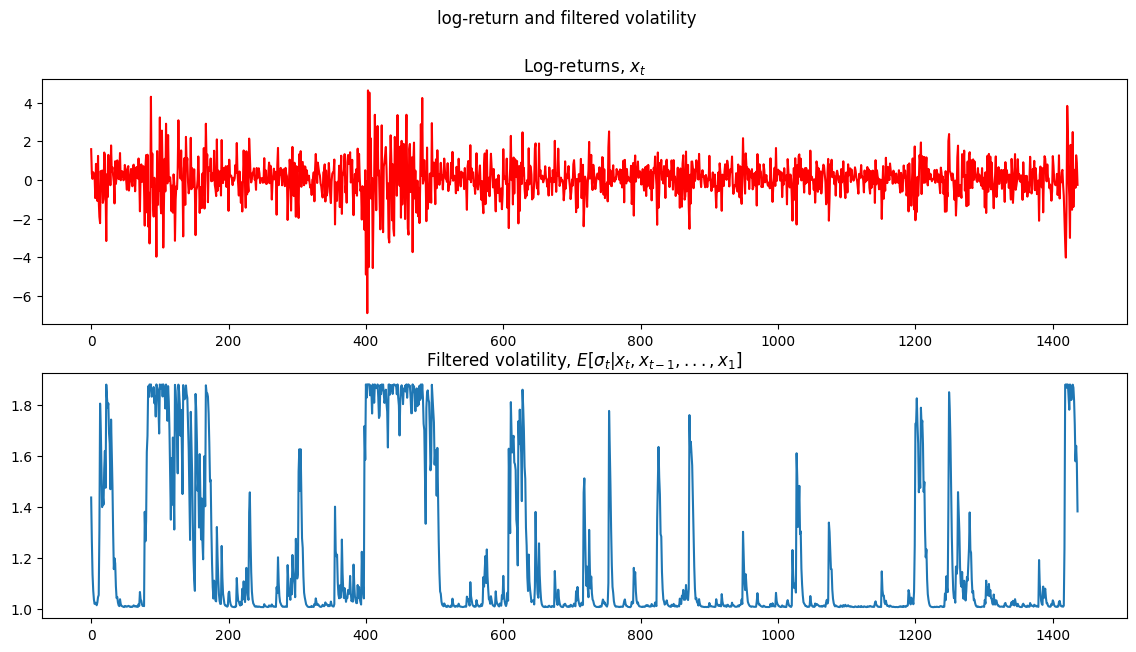

In [20]:

plot_my_data(data, filtered_volatility)



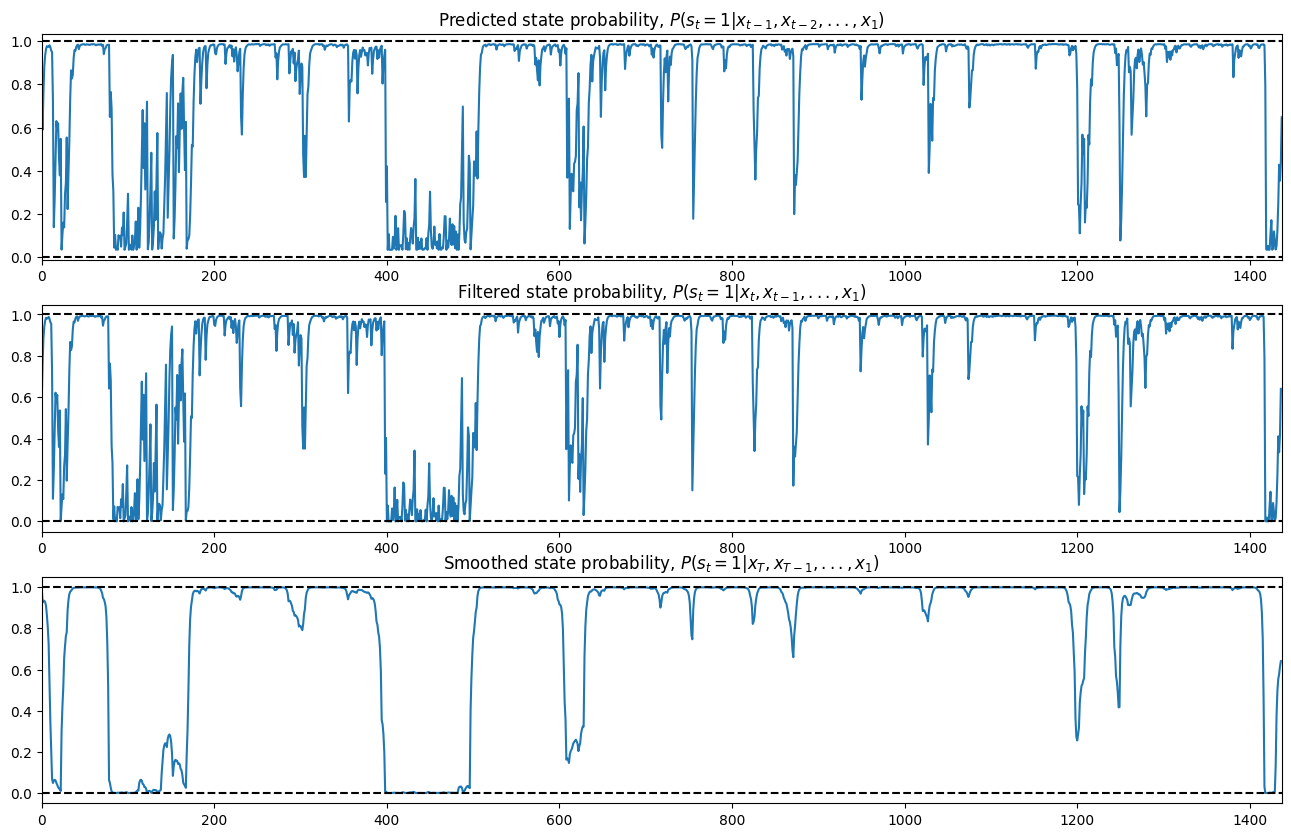

In [21]:
plot_my_probabilities(data, predicted_probabilities, filtered_probabilities, smoothed_probabilities)

# Backup


In [7]:
# n_states=2
# print(data)
# def parameterize(params):
#     """
#     takes parameters,
#     creates: 
#         p_00, p_11
#         the sigmas   

#     ! This is not expanded to fit n_states!   
#     """
#     p_00 = params[0]
#     p_11 = params[1]
#     sigma = params[2:4];
#     mu = params[4:6];
#     phi = params[6:8];
    
#     return p_00, p_11, sigma, mu, phi

# def create_transition_matrix(p_00, p_11):
#     """
#     Create the Transition Matrix 

#     ! This is not expanded to fit n_states!
#     """
#     transition_matrix = np.zeros([2, 2])
#     transition_matrix[0] = p_00, 1 - p_11
#     transition_matrix[1] = 1 - p_00, p_11
#     return transition_matrix

# def calculate_initial_probabilities(transition_matrix):
#     """
#     Use linalg to find the initial probabilities:

#     ! This is not expanded to fit n_states!
#     """
#     A_matrix = np.vstack(((np.identity(2)- transition_matrix), np.ones([1,2])))
#     pi_first = np.linalg.inv(A_matrix.T.dot(A_matrix)).dot(A_matrix.T)
#     pi_second = np.vstack((np.zeros([2,1]), np.ones([1,1])))
#     initial_probs = pi_first.dot(pi_second)
#     initial_probabilities = initial_probs.T
#     return initial_probabilities

# def density_function(t, state,sigma, mu, phi):
#     return np.exp(-0.5 * np.log(2 * np.pi) - 0.5 * np.log(sigma[state]) - 0.5 * ((data[t] - mu[state] - phi[state] * data[t-1]) ** 2) / sigma[state])


# def prediction_step(transition_matrix, filtered_probabilities, t):
#     """
#     Use the dot product of the transition_matrix and the filtered_probability
#     """  
#     predictions = transition_matrix.dot(filtered_probabilities[:,t])
#     return predictions

# def filtering_step(partial_likelihood, likelihood_contributions, t):
#     """
#     For State in n_states
#         Set filtered_pribabilities for a stateequal to partial_likelihood for the state divided by total likelihood.
#     """
#     filtered = np.zeros(n_states)
#     for state in range(n_states):
#         filtered[state] = partial_likelihood[state] / likelihood_contributions[t]
#     return filtered

# def objective(initial_guess):
#     """
#     Setup Arrays for Book Keeping
#     Create Parameters
#     for t in rainge(num_obs):
#         ...
#     """
#     # For Book Keeping
#     num_obs = len(data)
#     predicted_probabilities = np.zeros([n_states, num_obs+1])
#     filtered_probabilities = np.zeros([n_states, num_obs])
#     smoothed_probabilities = np.zeros([n_states, num_obs])
#     likelihood_contributions = np.zeros(num_obs)


#     # Form Model Parameters
#     p_00, p_11, sigma, mu, phi = parameterize(initial_guess)

#     # Form Transition Matrix
#     transition_matrix = create_transition_matrix(p_00, p_11)

#     # Form Initial Probabilities
#     predicted_probabilities[[0,1],0] = calculate_initial_probabilities(transition_matrix)

#     # To Hold values of Forward Filter Recursions
#     eta = np.zeros(n_states)
    
#     # To Hold values of Forward Filter Recursions
#     filters = np.zeros(n_states)
    
#     # To Hold values of Partial Log-Likelihoods.
#     partial_likelihood = np.zeros(n_states)

#     # The Main For Loop:
#     for t in range(num_obs):
#         # Calculate State Densities
#         for state in range(n_states):
#             eta[state] = density_function(t, state, sigma, mu, phi)
#             partial_likelihood[state] = predicted_probabilities[state,t] * eta[state]

#         # Calculate the Log-Likelihood

#         likelihood_contributions[t] = np.log(np.sum(partial_likelihood))

#         # Calculate the Filtering Step
#         num0 = eta[0] * predicted_probabilities[0,t] / (eta[0] * predicted_probabilities[0,t] + eta[1] * predicted_probabilities[1,t])
#         num1 = eta[1] * predicted_probabilities[1,t] / (eta[0] * predicted_probabilities[0,t] + eta[1] * predicted_probabilities[1,t])
#         filtered_probabilities[[0,1],t] = num0, num1
#         # filtered_probabilities[:,t] = filtering_step(partial_likelihood, likelihood_contributions, t)

#         # Calculate the Prediction step
#         predicted_probabilities[[0,1],t+1] = transition_matrix.dot(filtered_probabilities[[0,1],t])
#         #predicted_probabilities[:, t+1] = prediction_step(transition_matrix, filtered_probabilities, t)
        
        
        
#         # print(f' Likelihood Value :  {likelihood_contributions[t]}')
#         # print(f'  Predicted Probability:  {predicted_probabilities[:, t+1]}')
#         # print(f' Filtered Probability :  {filtered_probabilities[:,t] }')
#         # print(f'Eta  :  {eta}')
#         # print(f'Partial Likelihood  :  {partial_likelihood}')
#     # Return the Negative Sum of the Log-Likelihood
    
#     negative_likelihood = -np.sum(likelihood_contributions)

#     return negative_likelihood
    
# def fit(data):
#     """
#     Minimize the objective Function
#         Use initial Guess, constraints, bounds, and arguments.
#         Print results.
#     """

#     # Initial Guesses
#     variance = np.var(data)
#     initial_guess= np.array([0.9, 0.9, np.sqrt(2*variance), np.sqrt(0.5*variance),0,0,0,0])

#     # Parameter Bounds
#     my_bounds = bounds=((0.001,0.9999),(0.001,0.9999),(0.01,None),(0.01,None),(None,None),(None,None),(None,None),(None,None))

#     # Missing: Constraint, args 


#     res = minimize(objective, initial_guess, method='L-BFGS-B', bounds=my_bounds) # constraint=cons,arg=args)

#     # Hessian, standard errors, print etc
#     res.x
#     v_hessian = res.hess_inv.todense()
#     se_hessian = np.sqrt(np.diagonal(v_hessian))

#     # The Results:
#     estimated_parameters = res.x
#     se = se_hessian
#     print('P11='+str(estimated_parameters[0])+', std.errors='+str(se[0]))
#     print('P22='+str(estimated_parameters[1])+', std.errors='+str(se[1]))
#     print('h1='+str(estimated_parameters[2])+', std.errors='+str(se[2]))
#     print('h2='+str(estimated_parameters[3])+', std.errors='+str(se[3]))
#     print('mu1='+str(estimated_parameters[4])+', std.errors='+str(se[4]))
#     print('mu2='+str(estimated_parameters[5])+', std.errors='+str(se[5]))
#     print('phi='+str(estimated_parameters[6])+', std.errors='+str(se[6]))
#     print('phi2='+str(estimated_parameters[7])+', std.errors='+str(se[7]))

#     return estimated_parameters

# def smoothed(estimates):
    


# my_fitted = fit(data)

In [8]:
#Plotting returns and filtered probabilities
gamma=my_fitted
y = data
def GaussianDensity(y,m,s):
    return np.exp(-0.5*np.log(np.pi)-0.5*np.log(s)-0.5*((y-m)**2)/s)
#parameters
p00    = gamma[0]
p11    = gamma[1]
sigma2 = gamma[2:4]**2;
T      = len(y)
#//transition matrix
P = np.zeros([2,2])
P[0]=p00, 1-p11
P[1]=1-p00, p11
    
#//bookkeeping
xi_10      = np.zeros([2,T+1])
xi_11      = np.zeros([2,T])
xi_1T      = np.zeros([2,T])
lik        = np.zeros(T)

#//regression:
A  = np.vstack(((np.identity(2)-P),np.ones([1,2])))
pi_first = np.linalg.inv(A.T.dot(A)).dot(A.T)
pi_second=np.vstack((np.zeros([2,1]),np.ones([1,1])))
pi=pi_first.dot(pi_second)
xi_10[[0,1],0] = pi.T
#//forward filter recursion
eta=np.zeros(2)
for t in range(T):
    #//state densities
    eta[0]=GaussianDensity(y[t],0,sigma2[0])
    eta[1]=GaussianDensity(y[t],0,sigma2[1])
        
    #likelihood
    #print(np.log(xi_10[[0,1],t]))
    lik[t]   = np.log(xi_10[0,t]*eta[0]+xi_10[1,t]*eta[1])
        
    #filtering
    num0=eta[0]*xi_10[0,t]/(eta[0]*xi_10[0,t]+eta[1]*xi_10[1,t])
    num1=eta[1]*xi_10[1,t]/(eta[0]*xi_10[0,t]+eta[1]*xi_10[1,t])
    xi_11[[0,1],t] = num0,num1

    #prediction
    xi_10[[0,1],t+1] = P.dot(xi_11[[0,1],t])
    
    #Backward smoother (not needed for likelihood)
    xi_1T[:,T-1]=xi_11[:,T-1]
    for t in range(T-2,0,-1):
        xi_1T[:,t]=xi_11[:,t]*(P.T.dot(xi_1T[:,t+1]/xi_10[:,t+1]))
        
vol=np.zeros(len(y))
for i in range(T):
    vol[i]=xi_11[[0],i]*sigma2[0]+ (1-xi_11[[0],i])*sigma2[1]

/tmp/ipykernel_641966/3952031291.py:50: RuntimeWarning: invalid value encountered in divide
  xi_1T[:,t]=xi_11[:,t]*(P.T.dot(xi_1T[:,t+1]/xi_10[:,t+1]))
/tmp/ipykernel_641966/3952031291.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vol[i]=xi_11[[0],i]*sigma2[0]+ (1-xi_11[[0],i])*sigma2[1]


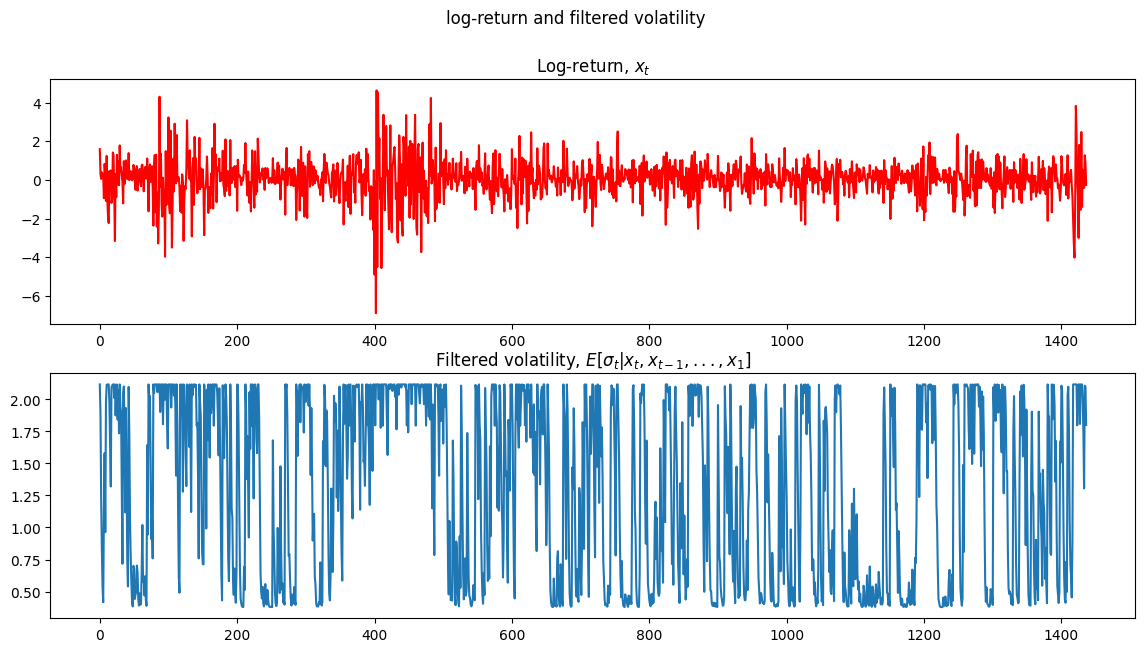

In [9]:
fig, ax=plt.subplots(2, figsize=(14,7))
#fig.set_figheight=(9)
#fig.set_figwidth=(16)
fig.suptitle('log-return and filtered volatility')
ax[0].plot(y,color='r')
ax[1].plot(np.sqrt(vol))

#Setting titles
ax[0].title.set_text('Log-return, $x_t$')
ax[1].title.set_text('Filtered volatility, $E[\sigma_t|x_t,x_{t-1},...,x_1]$')


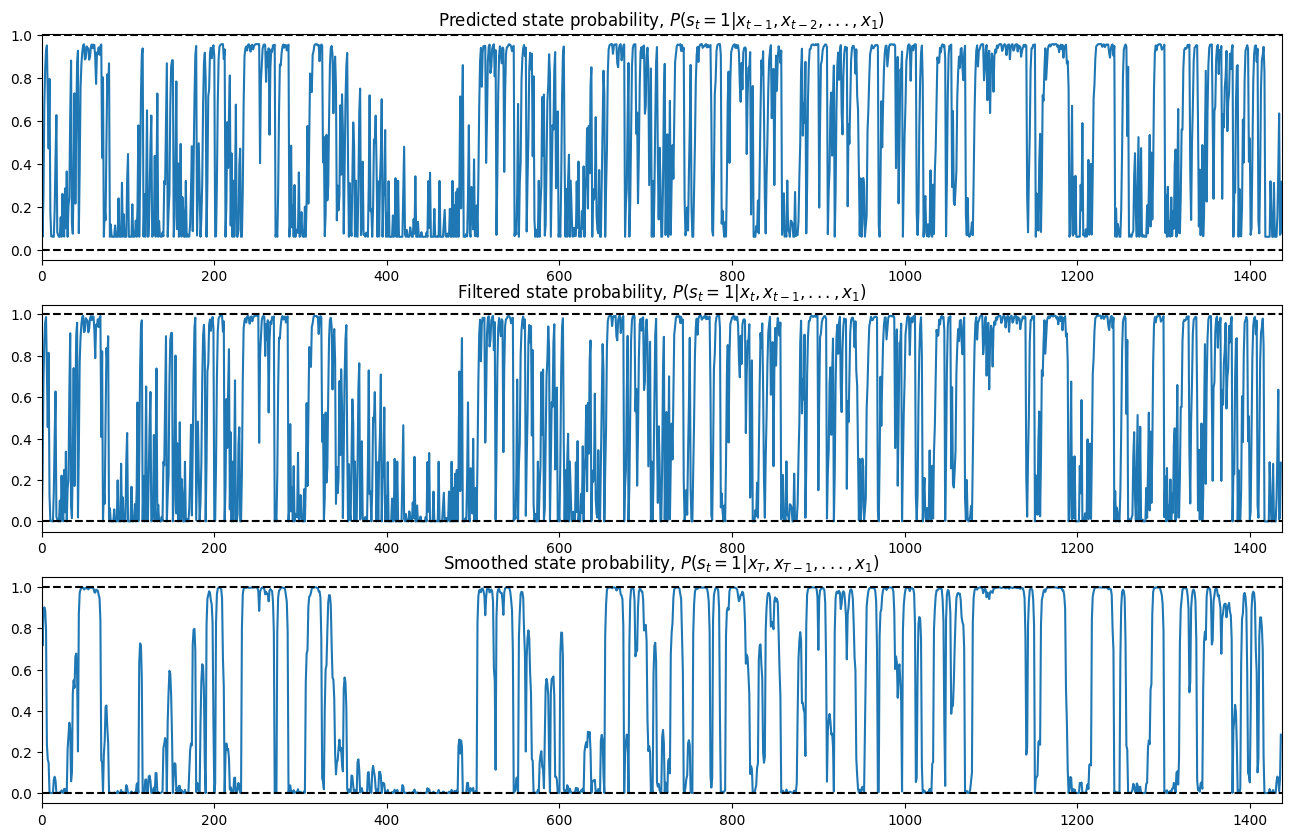

In [10]:
#Predicted state probability, Filtered state probability and smoothed state probability
fig, ax=plt.subplots(3, figsize=(16,9))
#fig.tight_layout() 

#Adjusting size between subplots
fig.subplots_adjust(left=None, bottom=0.025, right=None, top=None, wspace=None, hspace=None)
#default
#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots


ax[0].plot(1-xi_10[0,:])
ax[1].plot(1-xi_11[0,:])
ax[2].plot(1-xi_1T[0,:])

#Setting limits on x axis
ax[0].set_xlim(0, T)
ax[1].set_xlim(0, T)
ax[2].set_xlim(0, T)

#Setting titles
ax[0].title.set_text('Predicted state probability, $P(s_t=1|x_{t-1},x_{t-2},...,x_{1})$')
ax[1].title.set_text('Filtered state probability, $P(s_t=1|x_{t},x_{t-1},...,x_{1})$')
ax[2].title.set_text('Smoothed state probability, $P(s_t=1|x_{T},x_{T-1},...,x_{1})$')

#Setting lines at 0 and 1
ax[0].axhline(0,color='black', linestyle="--")
ax[0].axhline(1,color='black', linestyle="--")

ax[1].axhline(0,color='black', linestyle="--")
ax[1].axhline(1,color='black', linestyle="--")

ax[2].axhline(0,color='black', linestyle="--")
ax[2].axhline(1,color='black', linestyle="--")


In [11]:
poppopopofg

NameError: name 'poppopopofg' is not defined